In [ ]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
import h5py
import torch
import pickle
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split

In [ ]:
model_checkpoint_save_path = './models/checkpoints/'
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dtype)
print(device)

torch.float32
cuda:0


# Connect Colab and Google Drive

In [ ]:
# Path to where deeplearningproject is stored on drive that contains the data and the git repo (may have to be changed depending on user)
# Note can just use Colab terminal with git commands to commit, pull, push, etc. (Note have to follow this to push: https://stackoverflow.com/a/65951928/14018615)
# deep_learn_drive_path = '/content/drive/MyDrive/CS 6955/deeplearningproject/'
deep_learn_drive_path = '/content/drive/MyDrive/deeplearningproject/'
# To use with colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# cd into git repo
os.chdir(deep_learn_drive_path + 'cs-6955-deep-learning-final-project')
print('Git directory content: {0}'.format(os.listdir()))

Git directory content: ['PorousMaterialImageToYoungsModulusNet_dkbirky.ipynb', 'porositydata_howto.py', '.git', 'README.md', 'models', 'porositydataset.hdf5', '.gitignore', 'PorousMaterialImageToYoungsModulusNet.ipynb', 'porositydataset_resized.hdf5', 'PorousMaterialImageAndStrainToStressNet.ipynb', 'PorousMaterialImageAndStrainToMaterialPropertiesNet.ipynb', 'porositydataset_2000runs.hdf5']


In [ ]:
porosity_dataset_filename = 'porositydataset_2000runs.hdf5'
# porosity_dataset_filename = 'porositydataset.hdf5'

# Visualize Data

In [ ]:
##load the dataset
d = h5py.File(porosity_dataset_filename,'a')
print(d.keys())
#load original images
og_images = np.zeros(d['Original Images'].shape)
og_images[:,:,:] = d['Original Images']
#load deformed images
deformed_images = np.zeros(d['Deformed Images'].shape)
deformed_images[:,:,:] = d['Deformed Images']
#load stress-strain data
data = np.zeros(d['Data'].shape)
data[:,:,:] = d['Data']
#separate stresses/strains, stresses in MPa, strain is unitless
SMises = data[:,0,:] #von Mises stress
S11 = data[:,1,:] #stress in 11 direction
S22 = data[:,2,:] #stress in 22 direction
SP = data[:,3,:] #pressure stress
strain = data[:,4,:]*0.006 #strain (have to multiply by 0.006 to get value)
#load youngs moduli, units are GPa
E = np.zeros(d['Youngs Modulus'].shape)
E[:] = d['Youngs Modulus']


Youngs Modulus: 169.34269981089005 GPa
(2000, 256, 256, 3)


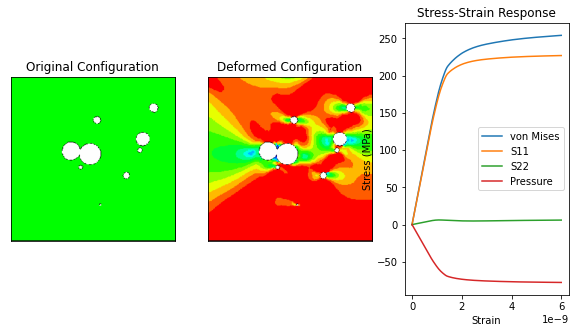



Youngs Modulus: 135.9029917741759 GPa
(2000, 256, 256, 3)


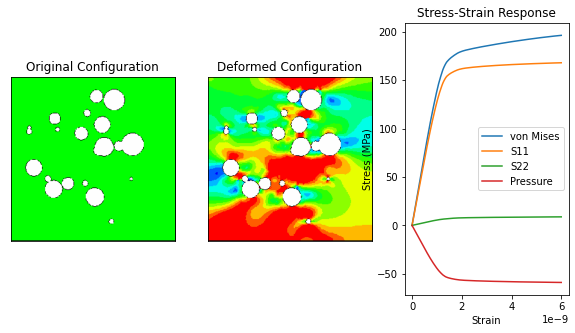



Youngs Modulus: 183.23642303249696 GPa
(2000, 256, 256, 3)


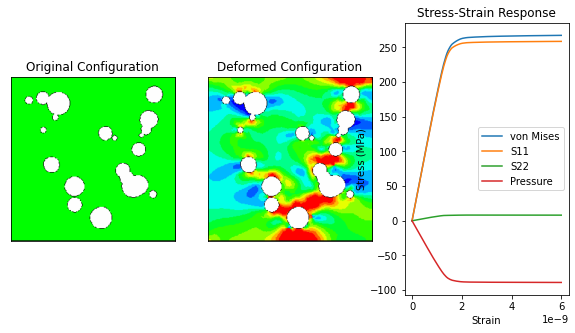



Youngs Modulus: 152.62857899875183 GPa
(2000, 256, 256, 3)


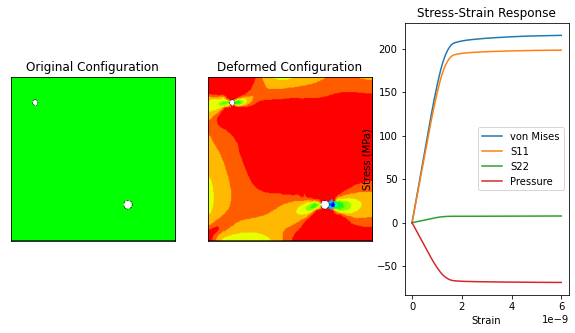



Youngs Modulus: 198.73067345644105 GPa
(2000, 256, 256, 3)


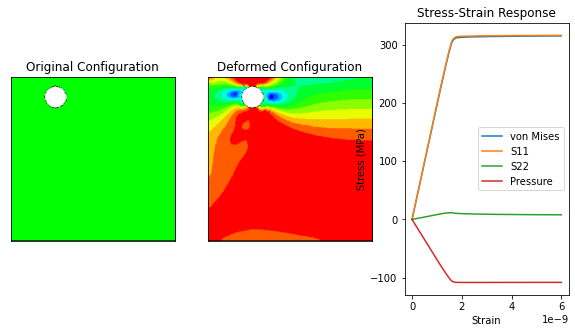

In [ ]:
for _ in range(5):
    #choose which run you want to look at
    run = random.randint(0, E.size-1)
    #print youngs modulus
    print('Youngs Modulus:',E[run],'GPa')
    #plot images and stress response
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.imshow(og_images[run,:,:,:].astype('uint8'))
    print(og_images.shape)
    ax1.title.set_text('Original Configuration')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(deformed_images[run,:,:,:].astype('uint8'))
    ax2.title.set_text('Deformed Configuration')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.plot(strain[run,:],SMises[run,:],label='von Mises')
    ax3.plot(strain[run,:],S11[run,:],label='S11')
    ax3.plot(strain[run,:],S22[run,:],label='S22')
    ax3.plot(strain[run,:],SP[run,:],label='Pressure')
    ax3.title.set_text('Stress-Strain Response')
    ax3.set_xlabel('Strain')
    ax3.set_ylabel('Stress (MPa)')
    ax3.legend()
    plt.show()
    print()
    print()
del d, og_images, deformed_images, data, SMises, S11, S22, SP, strain, E

# Create PyTorch Dataset 

In [ ]:
class PorousMaterialImageToYoungsModulusDataset(Dataset):
    def __init__(self, hdf5_porosity_path, img_transform=None):
        self.img_transform = img_transform
        ##load the dataset
        self.d = h5py.File(hdf5_porosity_path,'a')
        #load original images
        self.og_images = np.zeros(self.d['Original Images'].shape,dtype=int)
        self.og_images[:,:,:] = self.d['Original Images']
        #load deformed images
        # self.deformed_images = np.zeros(self.d['Deformed Images'].shape)
        # self.deformed_images[:,:,:] = self.d['Deformed Images']
        #load stress-strain data
        self.ss_data = np.zeros(self.d['Data'].shape)
        self.ss_data[:,:,:] = self.d['Data']
        #separate stresses/strains, stresses in MPa, strain is unitless
        self.SMises = self.ss_data[:,0,:] #von Mises stress
        self.S11 = self.ss_data[:,1,:] #stress in 11 direction
        self.S22 = self.ss_data[:,2,:] #stress in 22 direction
        self.SP = self.ss_data[:,3,:] #pressure stress
        self.strain = self.ss_data[:,4,:]*0.006 #strain (have to multiply by 0.006 to get value)
        #load youngs moduli, units are GPa
        self.E = np.zeros(self.d['Youngs Modulus'].shape)
        self.E[:] = self.d['Youngs Modulus']
        
    def __len__(self):
        return self.E.size

    def __getitem__(self, idx):
        og_image_idx = self.og_images[idx,:,:,:].astype('uint8')
        # deformed_image_idx = self.deformed_images[idx,:,:,:].astype('uint8')
        if (self.img_transform is not None):
            og_image_idx = self.img_transform(og_image_idx)
            # deformed_image_idx = self.img_transform(deformed_image_idx)
        SMises_idx = self.SMises[idx,:]
        S11_idx = self.S11[idx,:]
        S22_idx = self.S22[idx,:]
        SP_idx = self.SP[idx,:]
        strain_idx = self.strain[idx,:]
        E_idx = self.E[idx]
        # return og_image_idx, SMises_idx, S11_idx, S22_idx, SP_idx, SP_idx, strain_idx, E_idx
        # Have to decide what exactly to return here, depends on training task
        # For now will have og_image_idx be the feature and E_idx be the label
        image = og_image_idx
        label = E_idx
        return image, label

In [ ]:
# Load porous dataset into memory
porous_dataset = PorousMaterialImageToYoungsModulusDataset(porosity_dataset_filename, img_transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

In [ ]:
# Split into train and test
test_prop = 0.2
test_size = int(test_prop*len(porous_dataset))
train_size = len(porous_dataset) - test_size
porous_train_dataset, porous_test_dataset = random_split(porous_dataset, (train_size, test_size)) 

# Split train into train and val
val_prop = 0.2
val_size = int(val_prop*len(porous_train_dataset))
train_size = len(porous_train_dataset) - val_size
porous_train_dataset, porous_val_dataset = random_split(porous_train_dataset, (train_size, val_size)) 

In [ ]:
batch_size = 32
train_loader = DataLoader(porous_train_dataset, batch_size=batch_size, shuffle=True)

# Batch size doesn't really matter for testing
test_loader = DataLoader(porous_test_dataset)
val_loader = DataLoader(porous_val_dataset)

Label: 1.9467498444767564 GPa
torch.Size([3, 224, 224])


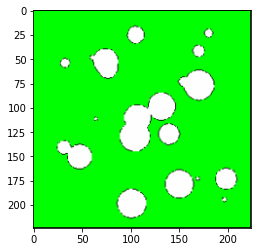



Label: 1.6841987888830994 GPa
torch.Size([3, 224, 224])


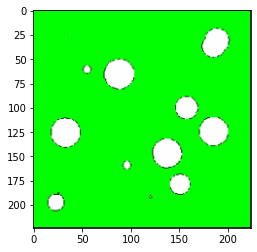



Label: 1.9682889047820986 GPa
torch.Size([3, 224, 224])


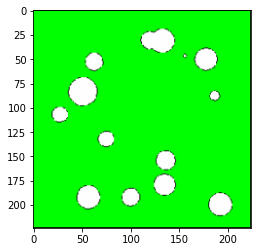



Label: 1.4069338901127169 GPa
torch.Size([3, 224, 224])


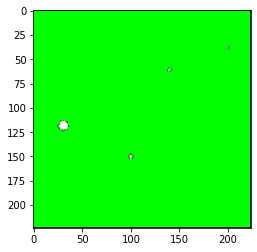



Label: 1.9670009917327747 GPa
torch.Size([3, 224, 224])


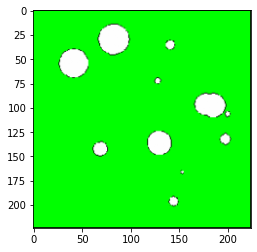



Label: 1.4704834049794824 GPa
torch.Size([3, 224, 224])


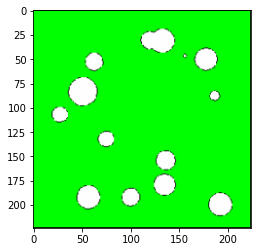



Label: 1.4863891231988646 GPa
torch.Size([3, 224, 224])


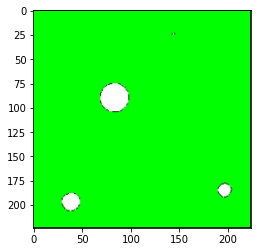



Label: 1.8228496285064335 GPa
torch.Size([3, 224, 224])


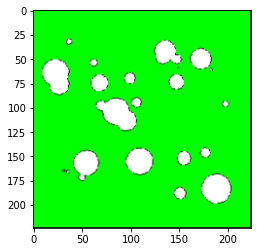



Label: 1.4199386547927053 GPa
torch.Size([3, 224, 224])


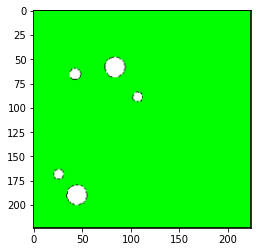



Label: 1.745414688900303 GPa
torch.Size([3, 224, 224])


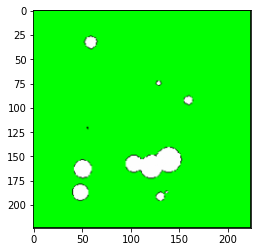



Label: 1.809494688301379 GPa
torch.Size([3, 224, 224])


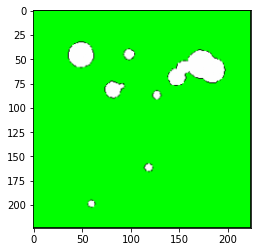



Label: 1.809341948292985 GPa
torch.Size([3, 224, 224])


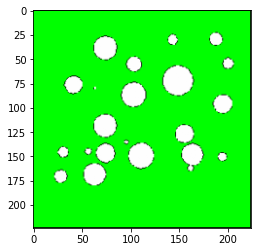



Label: 1.5357503925362166 GPa
torch.Size([3, 224, 224])


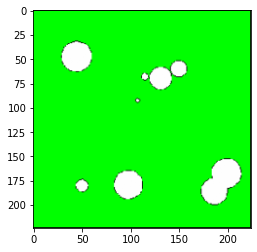



Label: 1.700080429785402 GPa
torch.Size([3, 224, 224])


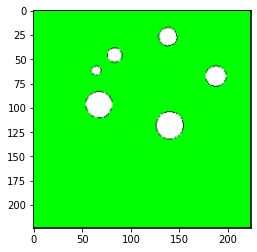



Label: 1.7080403261912553 GPa
torch.Size([3, 224, 224])


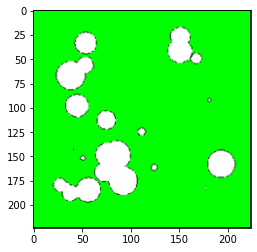



Label: 1.6222917344593453 GPa
torch.Size([3, 224, 224])


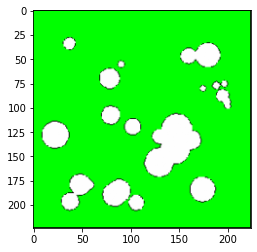



Label: 1.7541239099366805 GPa
torch.Size([3, 224, 224])


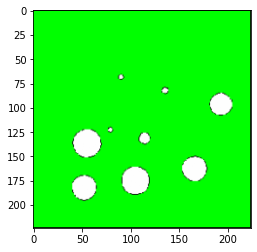



Label: 1.5717271359400697 GPa
torch.Size([3, 224, 224])


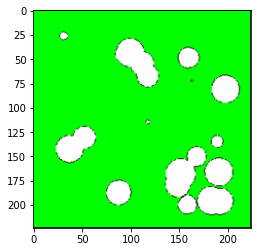



Label: 1.4739816946673707 GPa
torch.Size([3, 224, 224])


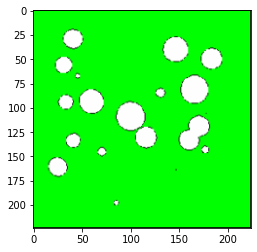



Label: 2.020482354455082 GPa
torch.Size([3, 224, 224])


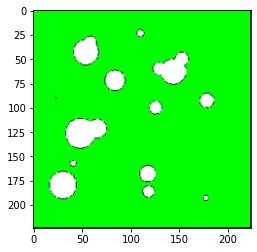



Label: 2.0124099354757017 GPa
torch.Size([3, 224, 224])


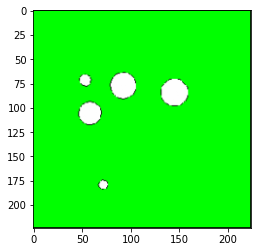



Label: 1.5093014778369684 GPa
torch.Size([3, 224, 224])


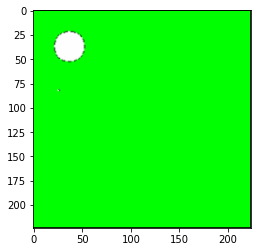



Label: 1.5875990319991629 GPa
torch.Size([3, 224, 224])


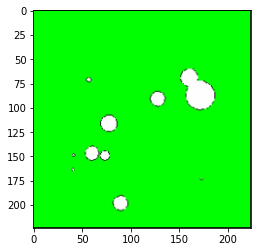



Label: 1.90653272875725 GPa
torch.Size([3, 224, 224])


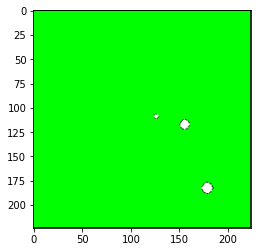



Label: 1.6079001929758545 GPa
torch.Size([3, 224, 224])


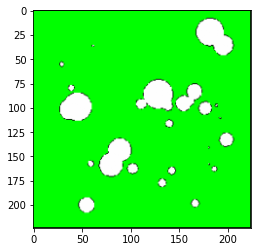



Label: 1.6369595693562837 GPa
torch.Size([3, 224, 224])


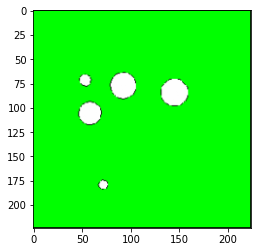



Label: 1.953629888172397 GPa
torch.Size([3, 224, 224])


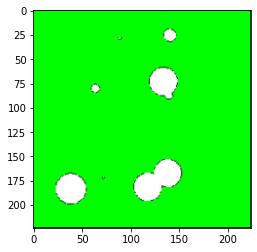



Label: 1.5262857899875184 GPa
torch.Size([3, 224, 224])


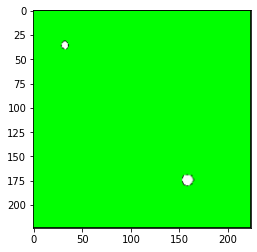



Label: 1.6311238727441784 GPa
torch.Size([3, 224, 224])


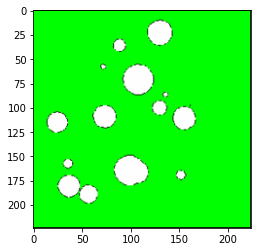



Label: 1.7908975585836335 GPa
torch.Size([3, 224, 224])


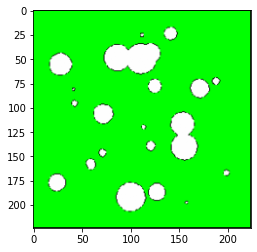



Label: 1.700080429785402 GPa
torch.Size([3, 224, 224])


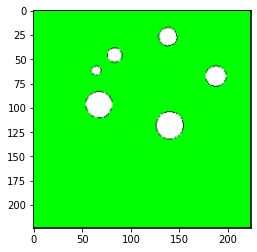



Label: 1.5810009219208363 GPa
torch.Size([3, 224, 224])


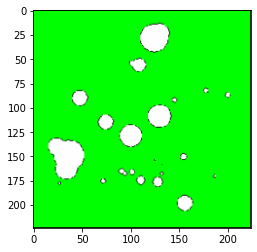

In [ ]:
# Visualize train data of a random batch 
viz_batch_idx = random.randint(0, len(train_loader)-1)
for i, batch in enumerate(train_loader):
    if i != viz_batch_idx:
        continue
    train_features, train_labels = batch
    for idx in range(len(train_features)):
        print("Label: {0} GPa".format(train_labels[idx].item()))
        plt.figure()
        print(train_features[idx].shape)
        plt.imshow(torch.movedim(train_features[idx], 0, 2))
        plt.show()
        print()
        print()


# Training

In [ ]:
# print(nn.Sequential(*list(models.squeezenet1_1(pretrained=True).children()))[:1])
class PorousMaterialImageToYoungsModulusNet(nn.Module):
    def __init__(self):
        super().__init__()
        squeeze_net_model = nn.Sequential(*list(models.squeezenet1_1(pretrained=True).children()))
        self.model = torch.nn.Sequential(
            squeeze_net_model,
            # nn.Conv2d(3,32,3),
            # nn.ReLU(),
            # nn.MaxPool2d(3),
            # nn.Conv2d(96,256,5),
            # nn.ReLU(),
            # nn.MaxPool2d(3),
            # nn.Conv2d(256,384,3),
            # nn.ReLU(),
            # nn.Conv2d(384,384,3),
            # nn.ReLU(),
            # nn.Conv2d(384,256,3),
            # nn.ReLU(),
            # nn.MaxPool2d(3),
            # nn.MaxPool2d(4),
            # nn.Conv2d(32,16,3),
            # nn.ReLU(),
            # nn.Conv2d(16,16,3),
            # nn.ReLU(),
            # nn.MaxPool2d(4),
            nn.Flatten(),
            # nn.Linear(2304,100),
            # nn.Linear(100,1)
            nn.Linear(1000,1)
            # nn.Linear(1000,100),
            # nn.Linear(100,1)
            # nn.Linear(10,1)
            )

    def forward(self, porous_material_image):
        scores = self.model(porous_material_image)
        return torch.flatten(scores, start_dim=1, end_dim=1)



In [ ]:
def get_PorousMaterialImageToYoungsModulusNet_accuracy(model, evaluation_dataloader, criterion):
    model.eval()
    model = model.to(device=device)
    total_MSE = 0
    num_vals = 0
    with torch.no_grad():
        for eval_val in evaluation_dataloader:
            feat, label, = eval_val
            feat = feat.to(dtype=dtype, device=device)
            label = label.to(dtype=dtype, device=device)

            pred_label = torch.flatten(model(feat))
            total_MSE += criterion(pred_label, label).cpu().item()
            num_vals += 1
    avg_MSE = total_MSE / num_vals
    return total_MSE, avg_MSE 

In [ ]:
model = PorousMaterialImageToYoungsModulusNet()

learning_rate = 1e-6
nepochs = 100 
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, )

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1236497


In [ ]:
num = 100
overfit_set, rest_set = random_split(porous_dataset, (num, 2000-num))
overfitloader = DataLoader(overfit_set)

0
Begin epoch 0
32139.429599609375
1
Begin epoch 1
31507.240390625
2
Begin epoch 2
31094.821884765624
3
Begin epoch 3
30794.49044921875
4
Begin epoch 4
30535.956142578125
5
Begin epoch 5
30265.873603515625
6
Begin epoch 6
29852.90333984375
7
Begin epoch 7
28783.70974609375
8
Begin epoch 8
24414.85990234375
9
Begin epoch 9
8826.475471191407
10
Begin epoch 10
708.9696233725361
11
Begin epoch 11
654.6805394104705
12
Begin epoch 12
584.5463720798492
13
Begin epoch 13
562.3082566097006
14
Begin epoch 14
511.417815345563
15
Begin epoch 15
495.36362855285404
16
Begin epoch 16
497.8616389083862
17
Begin epoch 17
484.8811687400937
18
Begin epoch 18
489.1796196173155
19
Begin epoch 19
487.3981719685346
20
Begin epoch 20
481.4174678052706
21
Begin epoch 21
467.41175534989685
22
Begin epoch 22
474.8389416741952
23
Begin epoch 23
470.97771071240305
24
Begin epoch 24
462.27885244783016
25
Begin epoch 25
467.2229627271369
26
Begin epoch 26
452.7548682848015
27
Begin epoch 27
448.56829969275975
28
Beg

KeyboardInterrupt: ignored

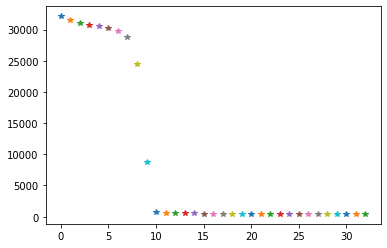

In [ ]:
model = model.to(device=device)
for e in range(nepochs):
  print(e)
  model.train() # Will put model in training mode
  print("Begin epoch {0}".format(e))
  for batch in overfitloader:
    train_features, train_labels = batch
    train_features = train_features.to(dtype=dtype, device=device)
    train_labels = train_labels.to(dtype=dtype, device=device)
    pred_labels = torch.flatten(model(train_features))
    loss = criterion(pred_labels, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  _, current_train_avg_MSE = get_PorousMaterialImageToYoungsModulusNet_accuracy(model, overfitloader, criterion)
  plt.plot(e,current_train_avg_MSE,'*')
  print(current_train_avg_MSE)
plt.show()

In [ ]:
train_avg_MSE_vals = []
val_avg_MSE_vals = []
date_str = datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
model_save_name = 'model_{0}.pt'.format(date_str)
model_save_path = '{0}{1}'.format(model_checkpoint_save_path, model_save_name)
model_training_info_name = 'model_{0}_training_info.pkl'.format(date_str)
model_training_info_name_path = '{0}{1}'.format(model_checkpoint_save_path, model_training_info_name)
best_val_avg_MSE = 1000  
model = model.to(device=device)
for e in range(nepochs):
    model.train() # Will put model in training mode
    print("Begin epoch {0}".format(e))
    for batch in train_loader:
    # batch = next(iter(train_loader))
      train_features, train_labels = batch
      train_features = train_features.to(dtype=dtype, device=device)
      train_labels = train_labels.to(dtype=dtype, device=device)

      pred_labels = torch.flatten(model(train_features))
      loss = criterion(pred_labels, train_labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    _, current_train_avg_MSE = get_PorousMaterialImageToYoungsModulusNet_accuracy(model, train_loader, criterion) # Will put model in eval mode
    _, current_val_avg_MSE = get_PorousMaterialImageToYoungsModulusNet_accuracy(model, val_loader, criterion) # Will put model in eval mode
    train_avg_MSE_vals.append(current_train_avg_MSE)
    val_avg_MSE_vals.append(current_val_avg_MSE)
    if current_val_avg_MSE < best_val_avg_MSE:
        torch.save({
            'epoch':e,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'avg_train_loss':current_train_avg_MSE,
            'avg_val_loss':current_val_avg_MSE
        }, model_save_path)
        best_val_avg_MSE = current_val_avg_MSE
    print("Epoch {0}: train avg MSE={1}, val avg MSE={2}\n\n".format(e, current_train_avg_MSE, current_val_avg_MSE))
with open(model_training_info_name_path, 'wb') as f:
    pickle.dump((train_avg_MSE_vals, val_avg_MSE_vals),f)


Begin epoch 0
Epoch 0: train avg MSE=523.365950012207, val avg MSE=532.8299532704754


Begin epoch 1
Epoch 1: train avg MSE=517.62275390625, val avg MSE=526.5221490361989


Begin epoch 2
Epoch 2: train avg MSE=522.6071491241455, val avg MSE=532.132037189429


Begin epoch 3
Epoch 3: train avg MSE=518.322936630249, val avg MSE=527.3838429913682


Begin epoch 4
Epoch 4: train avg MSE=526.7914596557617, val avg MSE=536.8882645124016


Begin epoch 5
Epoch 5: train avg MSE=518.8264392852783, val avg MSE=528.5292180285905


Begin epoch 6
Epoch 6: train avg MSE=525.8514259338378, val avg MSE=536.0468651114613


Begin epoch 7
Epoch 7: train avg MSE=516.5900379180908, val avg MSE=526.2050410959549


Begin epoch 8
Epoch 8: train avg MSE=515.9355461120606, val avg MSE=525.1288442231431


Begin epoch 9
Epoch 9: train avg MSE=525.7798194885254, val avg MSE=536.0117411692925


Begin epoch 10
Epoch 10: train avg MSE=520.3093200683594, val avg MSE=530.4323374560132


Begin epoch 11
Epoch 11: train avg 

## Display Training Results

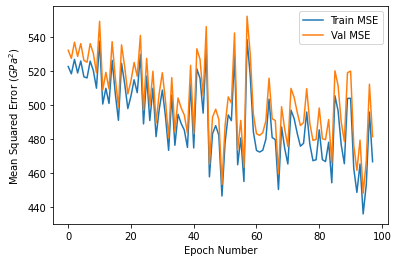

In [ ]:
with open(model_training_info_name_path, 'wb') as f:
    pickle.dump((train_avg_MSE_vals, val_avg_MSE_vals),f)
with open(model_training_info_name_path, 'rb') as f:
    train_avg_MSE_vals, val_avg_MSE_vals = pickle.load(f)
plt.figure()
plt.plot(train_avg_MSE_vals[2:], label='Train MSE')
plt.plot(val_avg_MSE_vals[2:], label='Val MSE')
plt.xlabel('Epoch Number')
plt.ylabel('Mean Squared Error ($GPa^2$)')
plt.legend()
plt.show()

In [ ]:
best_model = PorousMaterialImageToYoungsModulusNet()
best_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_checkpoint = torch.load(model_save_path)
best_epoch = best_checkpoint['epoch']
best_model.load_state_dict(best_checkpoint['model_state_dict'])
best_optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])
best_train_loss = best_checkpoint['avg_train_loss']
best_val_loss = best_checkpoint['avg_val_loss']

print('Best epoch = {0}, best train avg MSE loss = {1}, best val avg MSE loss = {2}'.format(best_epoch, best_train_loss, best_val_loss))

Best epoch = 96, best train avg MSE loss = 436.1734115600586, best val avg MSE loss = 448.2868676644233


## Test Results

In [ ]:
test_total_MSE, test_avg_MSE = get_PorousMaterialImageToYoungsModulusNet_accuracy(best_model, test_loader, criterion)

print('Best val set model: test total MSE = {0}GPa**2, test avg MSE = {1}GPa**2'.format(test_total_MSE, test_avg_MSE))
print('Best val set model: test total sqrt(MSE) = {0}GPa, test avg sqrt(MSE) = {1}GPa'.format(np.sqrt(test_total_MSE), np.sqrt(test_avg_MSE)))

Best val set model: test total MSE = 164767.75958748558GPa**2, test avg MSE = 411.91939896871395GPa**2
Best val set model: test total sqrt(MSE) = 405.91595138339363GPa, test avg sqrt(MSE) = 20.295797569169682GPa


In [ ]:
def get_PorousMaterialImageToYoungsModulusNet_labelsandpredictions(model, evaluation_dataloader, criterion):
    model.eval()
    model = model.to(device=device)
    total_MSE = 0
    num_vals = 0
    labels = []
    pred_labels = []
    with torch.no_grad():
        for eval_val in evaluation_dataloader:
            feat, label, = eval_val
            feat = feat.to(dtype=dtype, device=device)
            labels.append(label.to(dtype=dtype, device=device))

            pred_labels.append(torch.flatten(model(feat)))

    return pred_labels, labels

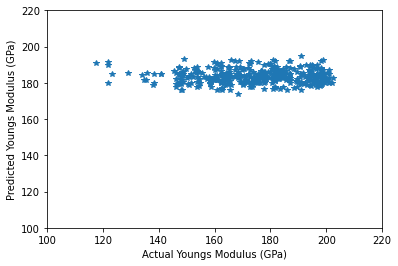

In [ ]:
test_pred_label, test_act_label = get_PorousMaterialImageToYoungsModulusNet_labelsandpredictions(best_model, test_loader, criterion)
plt.plot(test_act_label,test_pred_label,'*')
plt.xlim(100,220)
plt.ylim(100,220)
plt.xlabel('Actual Youngs Modulus (GPa)')
plt.ylabel('Predicted Youngs Modulus (GPa)')
plt.show()